# Sheet 03
This is the implementation of Sheet 02 of Awais Ahmed and Dominic Nieder.

In [76]:
from numpy.typing import NDArray  # trying to be typesafe
import numpy as np  # needed all over the place
from IPython.display import HTML # in line animations

import os   # file and file path

from itertools import count
import pandas as pd
import matplotlib.pyplot as plt  # for plots

from matplotlib import colors  # not quite sure what fore
from matplotlib.ticker import PercentFormatter  # also not sure, maybe animation..?
from matplotlib.animation import FuncAnimation, FFMpegWriter  # for animations

### Particle
* creating "Particle" class, containing all the information of all particle positions, velocities, mass and accellerations as well as interaction potential (all the object of class "Particle" shall interact by a Lennard-Jones Potential)

In [77]:
class Particle:
    def __init__(
        self,
        n: int,
        m: float | int,
        x: NDArray[np.float64],
        y: NDArray[np.float64],
        vx: NDArray[np.float64],
        vy: NDArray[np.float64],
    ):
        """
        Issue: No need to seperate x, y axis -> update all functions to take array([[x],[y]])
        """
        self.n: int = n
        self.m: float = float(m)

        self.x: NDArray[np.float64]= np.array(x, dtype=np.float64)
        self.y: NDArray[np.float64]= np.array(y, dtype=np.float64)

        self.vx: NDArray[np.float64]= np.array(vx, dtype=np.float64)
        self.vy: NDArray[np.float64]= np.array(vy, dtype=np.float64)

        self.ax1: NDArray[np.float64]= np.zeros(n, dtype=np.float64)
        self.ay1: NDArray[np.float64]= np.zeros(n, dtype=np.float64)
        self.ax2: NDArray[np.float64]= np.zeros(n, dtype=np.float64)
        self.ay2: NDArray[np.float64]= np.zeros(n, dtype=np.float64)
        
    def __repr__(self):
        return f"This is a particle at {self.x[0]}, {self.y[0]} with v={self.vx[0]},{self.vy[0]} interacting by Lennard-Jones potential."

### Initialisation of particles 
* saving any given data - e.g. position arguments

In [78]:
def save_array_to_file(
        txt_file_path: str,
        data_array: NDArray[np.float64]
) -> None:
    np.savetxt(txt_file_path,data_array, delimiter=' ')
    pass

* retrieving saved data, e.g. position arguments

In [79]:
def load_array_from_file(
        txt_file_path: str
) -> NDArray[np.float64]:
    """
    This function loads data from a file in txt_file_path. \n
    E.g. initial positions.
    """
    return np.loadtxt(txt_file_path,delimiter=' ')

* initiate particle positions on a grid

In [80]:
def initiate_positions_on_grid(
        n_particles: int,
        box: tuple[float|int, float|int]
) -> NDArray[np.float64]:
    """
    Returns n positions(x,y) that that are equally spaced on a grid, inside the box.
    """
    grid_sections = int(np.ceil(np.sqrt(n_particles)))  # find the number of colums & rows
    
    # even spacing
    x_spacing = box[0]/grid_sections 
    y_spacing = box[1]/grid_sections
    # makes grid coordinates
    x_positions, y_positions = np.meshgrid(
        np.arange(grid_sections) * x_spacing, 
        np.arange(grid_sections) * y_spacing
    )
    return np.array([x_positions.flatten()[:n_particles], y_positions.flatten()[:n_particles]])

* a seperate function to initiate velocities

In [81]:
def initiate_velocities(
        n_particles: int,
        velocity: float
) -> NDArray[np.float64]:
    return  velocity * (np.random.rand(2,n_particles) - 0.5)

* initialisation on a grid with radom velocity:


In [82]:
def initialize_particles_on_grid(
    n_particles: int, 
    box: tuple[float|int, float|int], 
    mass: float, 
    velocity: float,
    add_jitter: float= 0.0,
    data_file_location: str= "position_data.txt",
    load_positions: bool= False,
) -> Particle:
    """
    Particles a regular grid within a given spacing.\n
    Random velocity directions. \n
    Returns: Particle with initialized positions and velocities. 
    """
    positions=np.zeros( (2,n_particles) )
    if load_positions and os.path.isfile(data_file_location):  # load positions -> access save file
        print("loading positions from "+data_file_location+"!") 
        if np.shape(positions  ) == len(load_array_from_file(data_file_location)):
            positions+= load_array_from_file(
                data_file_location
                )
        else:
            pass
        
    else:  # do not load positions -> generate positions
        print("Initialiszing new positions")
        positions+= initiate_positions_on_grid(
            n_particles= n_particles,
            box= box
            )

        # adds jitter to the initial position, if jitter is 0.0 then there is no jitter
        positions+= (np.random.rand(2,n_particles)-0.5)* add_jitter

        # save positions -> reusability
        save_array_to_file(
            txt_file_path= data_file_location,
            data_array= positions
            )
        
    # Initialize velocities 
    v = initiate_velocities(n_particles=n_particles,velocity=velocity) 
    # Create and return a Particle
    return Particle(
        n=n_particles,
        m=mass,
        x=positions[0,:],
        y=positions[1,:],
        vx=v[0,:],
        vy=v[1,:]
    )

### Forces and Potentials
Lennard-Jones Potential and Force

In [83]:
def lJ_potentil(
        d: float|NDArray[np.float64]
) -> float|NDArray[np.float64]:
    """
    Lennard Jones Potential
    """
    c_12 = 9.847044*10**(-3)  #  J/mol
    c_6 = 6.2647225           #  J/mol 
    if d == 0:
        print("division by zero")
        return 0
    else:
        return c_12/d**12-c_6/d**6

def lj_force(
        d: float|int,
        r12: NDArray[np.float64]
) -> NDArray[np.float64]:
    """
    -> [fx,fy]\n
    Force by Lennard Jones interaction potential.\n
    d is the distance (scalar value).\n
    r12 is the relative coordinate (vecotr).\n
    Issue: -> invariant parameters c_12 and c_6; 
        -> include "if condition" for large forces
    """
    c_12 = 9.847044*10**(-3)  # J/mol
    c_6 = 6.2647225           # J/mol
    if d == 0:
        return np.array([0,0])
    else:
        return (12*c_12/d**13-6*c_6/d**7) * r12/d    

### Nearest Neighbour search
* the following functions allow for an appropriat nearest neighbour search

In [84]:
def rel_coordiante(
        r1: float,
        r2: float,
        box: float
) -> float:  
    """
    Returns relative coordinate between r1 and r2 with PBC. \n
    vec:r1 -> r2
    """
    return (r2 - r1 + box / 2) % box - box / 2
    

def distance(
        x: float| NDArray[np.float64],
        y: float| NDArray[np.float64]
) -> float | NDArray[np.float64]:
    """
    Takes relative ccordinates. \n
    Returns distance between two particles. \n
    """
    return np.sqrt(x**2+y**2)

### Velocity Verlet
The next functions are all concerned about the integrations and getting all the accelerations by using the Lennard Jones foce field, that was implemented above.

* integrating over positions

In [85]:
### position update
def integrate_position(
        particles: Particle,
        dt: float|int,
        box: tuple[float|int, float|int]
) -> None:
    """
    Velocity Verlet: Updates positions of particles.
    """
    particles.x+= particles.vx*dt+particles.ax1*dt*dt/2 
    particles.y+= particles.vy*dt+particles.ay1*dt*dt/2
    particles.x = particles.x%box[0]
    particles.y = particles.y%box[1]
    pass

* integrating over velocity

In [86]:
### updates velocity vectors
def integrate_velocity(
    particles: Particle,
    dt: float|int
) -> None:
    """
    Velocity Verlet: velocity integration.\n
    Updates velocities of particles.
    """
    particles.vx+=1/2 * (particles.ax1+particles.ax2)*dt
    particles.vy+=1/2 * (particles.ay1+particles.ay2)*dt
    pass

* updating the acceleration

In [87]:
### This funciton sets all the accelerations to zero
def reset_acceleration(
        particles: Particle
) -> None:
    """
    Sets particles.ax2 & particles.ay2 to zeros
    """
    particles.ax2=np.zeros(particles.n, np.float64)
    particles.ay2=np.zeros(particles.n, np.float64)
    pass

### Jitter on the acceleration c.f. to brownian motion
def jitter_acceleration(
        particles: Particle
) -> None:
    """
    Sets particles.ax2 & particles.ay2 to a small random number 
    """
    particles.ax2=np.random.rand(particles.n)*np.sqrt(0.0002)
    particles.ay2=np.random.rand(particles.n)*np.sqrt(0.0002)
    pass

def new_update_acceleration(
        particles: Particle,
        box: tuple[float|int,float|int],
)->None:
    """
    Iterates through all particles calculates force. \n
    \n\n
    Issue: \n-iteration through all particles n^2; \nSearching ~n log n\n
    Suggestion -> matrix multiplication with np-funciton.
    """
    reset_acceleration(particles= particles)
    for i in range(particles.n):
        for j in range(i+1,particles.n):
            # distnance in periodic boundry conditions 
            rel_x= rel_coordiante(r1=particles.x[i],r2=particles.x[j],box=box[0])
            rel_y= rel_coordiante(r1=particles.y[i],r2=particles.y[j],box=box[1])
            
            # calculating acceleration
            acceleration_ij= 1/particles.m * lj_force(
                distance(rel_x,rel_y),
                np.array([rel_x, rel_y])
            )

            # adding acceleration
            particles.ax2[i]-= acceleration_ij[0]
            particles.ay2[i]-= acceleration_ij[1]
            particles.ax2[j]+= acceleration_ij[0]
            particles.ay2[j]+= acceleration_ij[1]
    pass

### Simulation and main loops
* This function contains the integration funcitons, updates forces 

In [88]:
def iterate(
        dt: float|int,
        particles: Particle,
        box: tuple[float|int,float|int]
    ) -> None:
    """
    Updates positions and velocities. \n
    Accelerations for 1. iteration need to be obtained prior. 
    """
    particles.ax1=particles.ax2  # prior a(t+dt) -> a(t)
    particles.ay1=particles.ay2
    integrate_position(particles,dt,box)
    new_update_acceleration(particles,box)
    integrate_velocity(particles,dt)
pass

Next the 'main' simulation function is implemented. This iterates over all timesteps and saves the data of interest (phase space).

In [89]:
def simulate(
        particles: Particle, 
        time: int,
        dt: float|int, 
        box: tuple[float|int,float|int],
        data: NDArray[np.float64]
) -> NDArray[np.float64]:
    """
    Runs a simulation of n-particles in a box and saves phase-space coordinates to data.\n
    Returns data.
    """
    new_update_acceleration(particles,box)  # initial calculation for accelerations
    for t in range(time):  # iteration over all timestepps
        iterate(dt,particles,box)

        ### save data of interest
        data[t,0,:]=particles.x
        data[t,1,:]=particles.y
        data[t,2,:]=particles.vx
        data[t,3,:]=particles.vy
    return data

### Steepest decent algorithm

* function to calculate the potential Energy

In [90]:
def potential_Energy(
    position_x_data: NDArray[np.float64],
    position_y_data: NDArray[np.float64],
    box: tuple[float|int,float|int]
) -> float:
    """
    Takes posiiton arguments x, y for a **time T** and a box as input. \n
    Returns Total potential Energy as a function of time.
    """
    e=0.0
    # iteration of particle pairs
    for i in range(len(position_x_data[:])):
        dx= rel_coordiante(position_x_data[i],position_x_data[i+1:len(position_x_data)],box[0])
        dy= rel_coordiante(position_y_data[i],position_y_data[i+1:len(position_y_data)],box[1])
        e+= np.sum(np.array(list(map(
                lJ_potentil,
                np.array(list(map(distance,dx,dy)))
                )))
            )
    return e

* this is the brute force was of steepest decent:
1st move particle in direction of force   

In [91]:
def normalize_acceleration(
        particles: Particle
) -> None:
    """
    Vectorized normalization of each particle's acceleration vector.
    """
    # Calculate the norm of each acceleration vector
    norms = np.sqrt(particles.ax2**2 + particles.ay2**2)

    # Avoid division by zero 
    norms = np.where(norms == 0, 1, norms)
    
    # Normalize the acceleration components
    particles.ax2 /= norms
    particles.ay2 /= norms
    
    # 

def re_scale_acceleration(
        particles: Particle,
        scaling_factor: float
) -> None:
    """
    scales the acceleration vector ax2, ay2 of the particles to the given length of the scaling factor
    """
    # First normalize the accelerations
    normalize_acceleration(particles)
    #print("After normalization (mean length):", (np.sqrt(particles.ax2**2 + particles.ay2**2)))

    # Rescale by the scaling factor
    particles.ax2 *= scaling_factor
    particles.ay2 *= scaling_factor
    #print("After rescaling (mean length):", (np.sqrt(particles.ax2**2 + particles.ay2**2)))

### Steepest decent algorithm
def steepest_decent(
        particles: Particle,
        box: tuple[float|int, float|int],
        step_size: float,
        energy_tolerance: float= 10**(-5)
) -> NDArray[np.float64]:
    """
    Takes (randomly initiated) partilces and finds (local) minimum with precission of minimum precision. \n
    The velocities should be zero and reinitialised after the minimization.
    """
    # data arrays for debugging
    posx_data= np.array([particles.x])
    posy_data= np.array([particles.y])
    energy_data= np.array([potential_Energy(
            position_x_data= particles.x,
            position_y_data= particles.y,
            box= box
        )])
        
    # determine direction
    new_update_acceleration(particles=particles, box=box)
    re_scale_acceleration(particles=particles, scaling_factor=step_size)
    
    # update positions
    particles.x= (particles.x+particles.ax2)%box[0]
    particles.y= (particles.y+particles.ay2)%box[1]

    energy_data= np.append(energy_data, [potential_Energy(
            position_x_data= particles.x,
            position_y_data= particles.y,
            box= box
        )])
    posx_data=np.append(posx_data, [particles.x], axis=0)
    posy_data=np.append(posy_data, [particles.y], axis=0)
    
    while energy_data[-1] <= energy_data[-2] and abs(energy_data[-1] - energy_data[-2]) > energy_tolerance:
        #print("while loop\ne_pot_new=",e_pot_new)
        #print("e_pot_old=", e_pot_old)
        new_update_acceleration(particles=particles, box=box)
        re_scale_acceleration(particles=particles, scaling_factor=step_size)
        #print("force direction:\n", particles.ax2, particles.ay2)

        # update positions
        particles.x= (particles.x+particles.ax2)%box[0]
        particles.y= (particles.y+particles.ay2)%box[1]
        #print("epot_next",e_pot_new)
        energy_data= np.append(energy_data,potential_Energy(
                position_x_data= particles.x,
                position_y_data= particles.y,
                box= box
            ))
        posx_data= np.append(posx_data, [particles.x], axis=0)
        posy_data= np.append(posy_data, [particles.y], axis=0)
        # print("energy",energy_data[-1])

    particles.x = (particles.x-particles.ax2)%box[0]
    particles.y = (particles.y-particles.ay2)%box[1]
    posx_data= np.append(posx_data, [particles.x], axis=0)
    posy_data= np.append(posy_data, [particles.y], axis=0)
    energy_data= np.append(energy_data,potential_Energy(
                position_x_data= particles.x,
                position_y_data= particles.y,
                box= box
            ))
    return energy_data, posx_data, posy_data

### Analysis
Here functions that analyse the data will be implemented. Animation, Potential and Kinetic Energies. 
* First of funcitons for animation

In [92]:
def animate(
        frame,
        x_data: NDArray[np.float64],
        y_data: NDArray[np.float64], 
        scat
):
    """
    Takes x and y data [time, particle]; init funciton for "creat_animation"
    """
    positions = np.c_[x_data[frame, :], y_data[frame,:]]
    scat.set_offsets(positions)
    return scat,

def animation_plot(
    p_radius: float|int,
    box: tuple[float|int]
):
    """
    takes box size and particle radius. Initation for "creat_animation"
    """
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], s=p_radius)  # Scale size for visibility
    ax.set_xlim(box[0])
    ax.set_ylim(box[1])
    ax.set_title("Simulation Visualization")
    ax.set_xlabel("X [nm]")
    ax.set_ylabel("Y [nm]")
    return scat, fig, ax

def creat_animation(
        save_animation: bool,
        animation_name: str,
        animation_box: tuple[int,int],
        x_data: NDArray[np.float64],
        y_data: NDArray[np.float64]
) -> FuncAnimation: 
    """
    x- and y_data has the form of [time, paritcle]. \n
    Saves the animation if save_animation = True.
    """
    scat, fig, ax = animation_plot(10, animation_box)
    anim = FuncAnimation(fig, animate, frames=len(x_data[:,0]), fargs=(x_data, y_data, scat), interval=20, blit=True)
    writer = FFMpegWriter(fps=10, metadata=dict(artist='Dominic Nieder'), bitrate=1800)
    if save_animation:
        anim.save(animation_name+".mp4")
    return anim

* Analysis of the kinetic Energy: $E=\frac{1}{2} \Sigma_i m_i |v_i|^2$ 

In [93]:
def kinetic_Energy(
        velocity_x_data: NDArray[np.float64],
        velocity_y_data: NDArray[np.float64],
        mass: float | NDArray[np.float64]
) -> NDArray[np.float64]:  
    """
    Takes velocity Data. \n
    Returns kinetic Energy as a funciton of time.
    """
    ekin = mass/2*np.sum((np.square(velocity_x_data)+np.square(velocity_y_data)),1)
    return ekin

* Potential Energy as defined above in lj_potential

In [94]:
def analyse_potential_Energy(
    position_x_data: NDArray[np.float64],
    position_y_data: NDArray[np.float64],
    box: tuple[float|int,float|int]
) -> NDArray[np.float64]:
    """
    Takes posiiton arguments x(t), y(t) and a box as input. \n
    Returns Total potential Energy as a function of time.
    """
    e=np.zeros(len(position_x_data[:,0]))
    # iteration over every time step -> function of time 
    for T in range(len(position_x_data[:,0])):
        # iteration of particle pairs
        for i in range(len(position_x_data[0,:])):
            dx=rel_coordiante(position_x_data[T,i],position_x_data[T,i+1:len(position_x_data[1])],box[0])
            dy=rel_coordiante(position_y_data[T,i],position_y_data[T,i+1:len(position_y_data[1])],box[1])
            d = map(distance,dx,dy)
            e[T]+= np.sum(np.array(list(map(lJ_potentil,d))))
    return e

* Temperature will be calculated by $<E_{kin}> = \frac{f}{2}kT$ or $T=\frac{2<E_{kin}>}{kf}$, where k is the Boltzmankonstant and Temperature $T$

In [95]:
def temperature_curve(  
        dof: int,  # degrees of freedom
        e_kin: NDArray[np.float64],
        n_particles: int,
) -> NDArray[np.float64]:
    k = 1.380649*10**(-23)  # J/K
    return 2*(e_kin/n_particles)/dof/k

### Code execution
Next I define all the variables and data list and use the simulation function with particles that shall be initialised on a grid.

#### Defining constants and variables

In [96]:
### Defining constants
N_PARTICLES: int = 100

PARTICLE_MASS: float = 18*10**(-3)  # kg/mol -> same units!

VELOCITY: float = 150 #  nm/ns

TIME_STEPS: int = 2000

DT: float = 0.002  # ns

BOX: tuple[int, int] = (5,5)

INITIAL_JITTER: float = 3.0

SAVE_MP4: bool = False

### initiating data array
data: NDArray[np.float64] = np.zeros((TIME_STEPS,len(BOX)**2,N_PARTICLES)) # (Time, len(x,y,vx,vy), N)

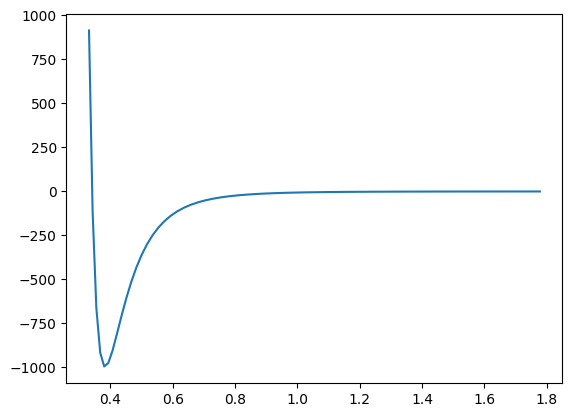

In [97]:
x=np.logspace(-0.48,0.25)
y=list(map(lJ_potentil,x))

plt.plot(x,y)
plt.show()
plt.close()


#### Initialisation of Particles and optimization

Initialiszing new positions


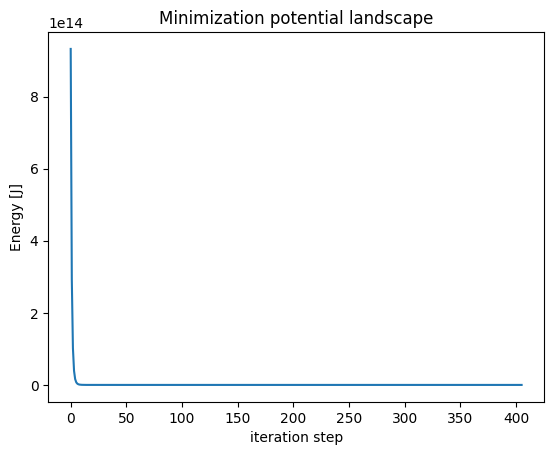

In [ ]:
particels= initialize_particles_on_grid(
        n_particles=N_PARTICLES,
        box=BOX,
        mass=PARTICLE_MASS, 
        velocity=VELOCITY, 
        add_jitter=3.0,
        data_file_location= "position_init.txt",
        load_positions= False
)

### check the steepest decent
pot_energy, x, y= steepest_decent(
        particles= particels,
        box= BOX,
        step_size= 0.002,  # nm
    )

### Understanding the minimization process
plt.title("Minimization potential landscape")
plt.plot(np.arange(len(pot_energy)),pot_energy, label="tot pot. Energy")
plt.xlabel("iteration step")
plt.ylabel("Energy [J]")
plt.grid(True)
plt.savefig("steepest_descent_jitter.png")
plt.show()
plt.close()

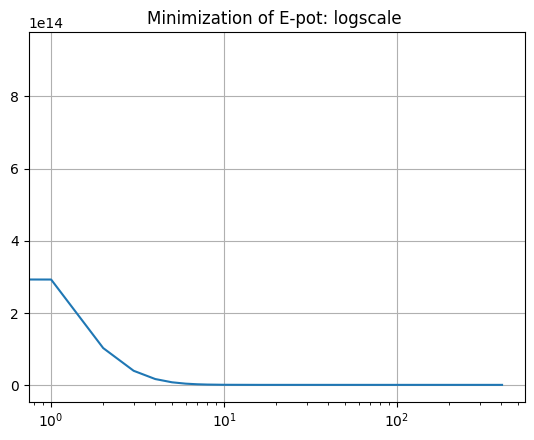

In [106]:
plt.plot(np.arange(len(pot_energy)),pot_energy, label="tot pot. Energy")
plt.title("Minimization of E-pot: logscale ")
#plt.xscale("log")
plt.xscale("log")
plt.grid()
plt.show()
plt.close()

#### Simulation

Simulation done!


KeyboardInterrupt: 

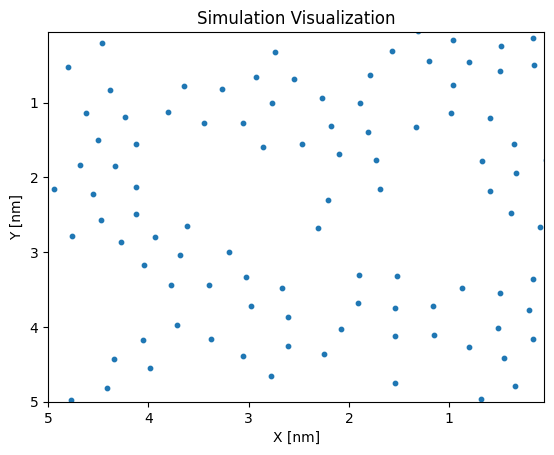

In [107]:
# data= simulate(
#         particles=particels
#         time=TIME_STEPS,  # timesteps
#         dt=DT,  # ns
#         box=BOX,  
#         data=data  # Time, phase-space pp, particles
#     )

print("Simulation done!")

mp4_SD = creat_animation(True, "steepest_decent_jitter", BOX,x_data=x,y_data=y)
HTML(mp4_SD.to_html5_video())

#mp4 = creat_animation(SAVE_MP4, "sheet02-animation_init-acc-jitter1",BOX, data[:,0,:],data[:,1,:])  
#HTML(mp4.to_html5_video())

* Analysis of Energies

In [ ]:
plot_name=""

# timestep_array=np.arange(time_steps) * dt
# e_kin = kinetic_Energy(data[:,2,:],data[:,3,:],paritcle_mass)
# e_pot = potential_Energy(data[:,0,:], data[:,1,:],box)
# temperature = temperature_curve(len(box),e_kin, n_particles)
# 
# fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=False)
# 
# set_cutoff= 20000
# axs[0].plot(timestep_array[:set_cutoff], e_kin[:set_cutoff],label="kin.")
# axs[0].plot(timestep_array[:set_cutoff], -e_pot[:set_cutoff],label="pot.")
# axs[1].plot(timestep_array[:set_cutoff], temperature[:set_cutoff], label="temp.")
# axs[0].set_xlabel('time [ns]')   
# axs[1].set_xlabel('time [ns]')
# axs[0].set_ylabel('Energy in [J]')  # find correct units of energy
# axs[1].set_ylabel('T in [K]') 
# axs[0].set_title('Energies')
# axs[1].set_title('Temperature')
# axs[0].legend()
# axs[1].legend()
# plt.savefig(plot_name+".png")
# plt.close()




In [ ]:
# plt.scatter(data[0,0,:],data[0,1,:])
# plt.title("initialisation with jitter")
# plt.ylabel("y [nm]")
# plt.xlabel("x [nm]")
# plt.savefig("sheet02-jitterinit")
# plt.close()